In [2]:
!pip install xgboost

   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.3/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.3/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.3/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.5/150.0 MB 442.1 kB/s eta 0:05:39
   ---------------------------------------- 0.8/150.0 MB 550.1 kB/s eta 0:04:32
   ---------------------------------------- 0.8/150.0 MB 550.1 kB/s eta 0:04:32
   ---------------------------------------- 1.0/15

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import matplotlib.pyplot as plt
import joblib

In [4]:
# Load data from Excel file
excel_file = 'Training.xlsx'  # Change this to your actual file path
df = pd.read_excel(excel_file, sheet_name='Sheet1')  # Adjust sheet name if needed

In [5]:
# Encode categorical variables
categorical_cols = ['Arr_Season', 'Location', 'Type']
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Convert boolean to int (ensure column name matches your Excel)
# Column name might need adjustment based on actual Excel header
weekend_col = 'Is_Week_End(arr)'  # Change if different in your Excel
df[weekend_col] = df[weekend_col].astype(int)

In [6]:
# Select features and target
features = [
    'Reservation_Day', 'Reservation_Month', 
    'Arrival_Day', 'Arr_Month_nbre',
    weekend_col, 'Arr_Season', 
    'Location', 'Type', 'Nbre-Etoile', 
    'Booking_Lead'
]

target = 'Demand_Multiplier_res'

In [11]:
X = df[features]
y = df[target]

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [12]:
# Create DMatrix for XGBoost native interface (supports early stopping)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [13]:
# Parameters for XGBoost
params = {
    'objective': 'reg:squarederror',
    'learning_rate': 0.05,
    'max_depth': 6,
    'min_child_weight': 1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'gamma': 0,
    'reg_alpha': 0,
    'reg_lambda': 1,
    'eval_metric': ['rmse', 'mae']
}

In [14]:
# Train model with early stopping
evals_result = {}
model = xgb.train(
    params,
    dtrain,
    num_boost_round=1000,
    evals=[(dtrain, 'train'), (dtest, 'test')],
    early_stopping_rounds=50,
    evals_result=evals_result,
    verbose_eval=10
)

[0]	train-rmse:0.17849	train-mae:0.15828	test-rmse:0.17853	test-mae:0.15810
[10]	train-rmse:0.13177	train-mae:0.11827	test-rmse:0.13171	test-mae:0.11798
[20]	train-rmse:0.10694	train-mae:0.09323	test-rmse:0.10683	test-mae:0.09291
[30]	train-rmse:0.09632	train-mae:0.08050	test-rmse:0.09621	test-mae:0.08025
[40]	train-rmse:0.09128	train-mae:0.07408	test-rmse:0.09118	test-mae:0.07387
[50]	train-rmse:0.08880	train-mae:0.07073	test-rmse:0.08873	test-mae:0.07059
[60]	train-rmse:0.08714	train-mae:0.06879	test-rmse:0.08708	test-mae:0.06866
[70]	train-rmse:0.08568	train-mae:0.06729	test-rmse:0.08563	test-mae:0.06718
[80]	train-rmse:0.08455	train-mae:0.06628	test-rmse:0.08452	test-mae:0.06618
[90]	train-rmse:0.08363	train-mae:0.06546	test-rmse:0.08358	test-mae:0.06535
[100]	train-rmse:0.08265	train-mae:0.06465	test-rmse:0.08261	test-mae:0.06455
[110]	train-rmse:0.08171	train-mae:0.06390	test-rmse:0.08171	test-mae:0.06383
[120]	train-rmse:0.08105	train-mae:0.06336	test-rmse:0.08108	test-mae:0.063

In [15]:
# Make predictions
y_pred = model.predict(dtest)

In [16]:
# Evaluate model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [17]:
print("\nModel Evaluation Metrics:")
print(f"Mean Squared Error: {mse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"R-squared: {r2:.4f}")


Model Evaluation Metrics:
Mean Squared Error: 0.0043
Mean Absolute Error: 0.0512
R-squared: 0.8748


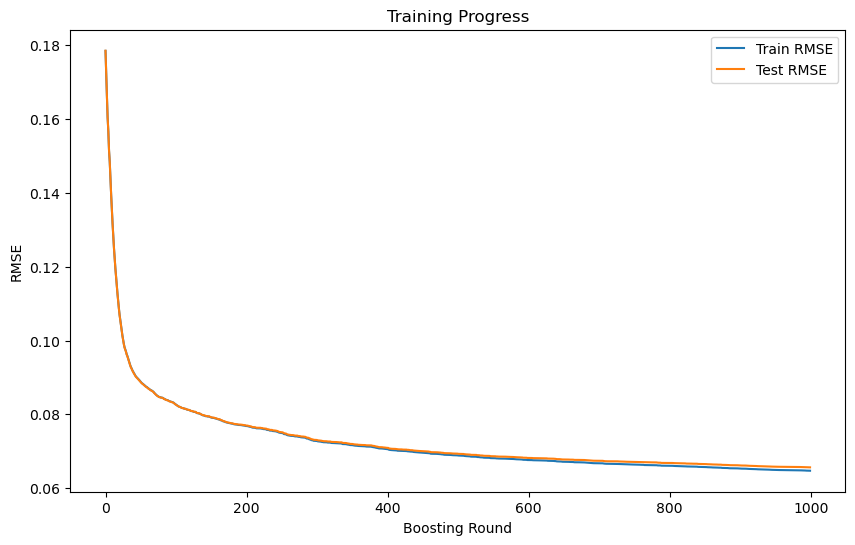

In [18]:
# Plot training progress
plt.figure(figsize=(10, 6))
plt.plot(evals_result['train']['rmse'], label='Train RMSE')
plt.plot(evals_result['test']['rmse'], label='Test RMSE')
plt.xlabel('Boosting Round')
plt.ylabel('RMSE')
plt.title('Training Progress')
plt.legend()
plt.show()

<Figure size 1000x800 with 0 Axes>

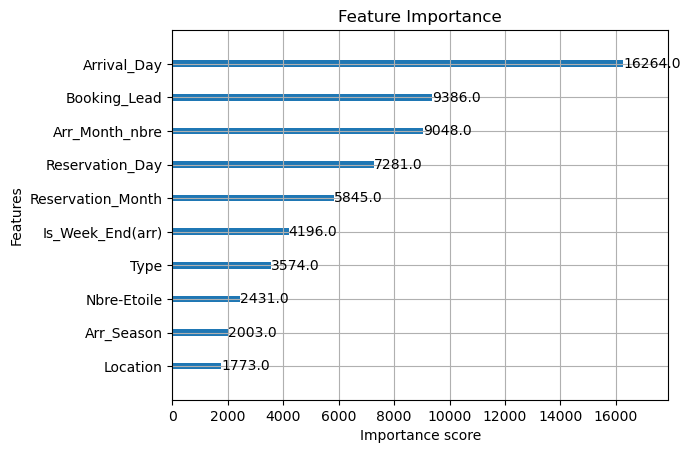

In [19]:
# Feature importance
plt.figure(figsize=(10, 8))
xgb.plot_importance(model)
plt.title('Feature Importance')
plt.show()

In [20]:
# Save model and encoders
model.save_model('hotel_demand_xgb_model.json')
joblib.dump(label_encoders, 'label_encoders.pkl')

['label_encoders.pkl']

In [21]:
print("\nModel and encoders saved successfully:")
print("- hotel_demand_xgb_model.json")
print("- label_encoders.pkl")


Model and encoders saved successfully:
- hotel_demand_xgb_model.json
- label_encoders.pkl


In [35]:
def predict_demand_multiplier(new_data):
    """
    Predicts the demand multiplier for a new hotel booking entry.
    
    Args:
        new_data (dict): Dictionary containing the features for prediction. 
                         Expected format:
                         {
                             'Reservation_Date': 'YYYY-MM-DD',
                             'Arrival_Date': 'YYYY-MM-DD',
                             'Is_Week_End(arr)': bool,
                             'Arr_Season': str,
                             'Location': str,
                             'Type': str,
                             'Nbre-Etoile': int,
                             'Booking_Lead': int (optional - will be calculated if not provided)
                         }
    
    Returns:
        float: Predicted demand multiplier
    """
    # Load the saved model and encoders
    model = xgb.Booster()
    model.load_model('hotel_demand_xgb_model.json')
    label_encoders = joblib.load('label_encoders.pkl')
    
    # Convert input data to DataFrame
    input_df = pd.DataFrame([new_data])
    
    # Parse dates and extract features
    input_df['Reservation_Date'] = pd.to_datetime(input_df['Reservation_Date'])
    input_df['Arrival_Date'] = pd.to_datetime(input_df['Arrival_Date'])
    
    # Calculate date-based features
    input_df['Reservation_Day'] = input_df['Reservation_Date'].dt.day
    input_df['Reservation_Month'] = input_df['Reservation_Date'].dt.month
    input_df['Arrival_Day'] = input_df['Arrival_Date'].dt.day
    
    # Calculate Booking_Lead if not provided
    if 'Booking_Lead' not in input_df.columns:
        input_df['Booking_Lead'] = (input_df['Arrival_Date'] - input_df['Reservation_Date']).dt.days
    
    # Encode categorical variables with error handling
    for col in ['Arr_Season', 'Location', 'Type']:
        le = label_encoders[col]
        # Handle unseen categories by mapping them to 'unknown'
        input_df[col] = input_df[col].apply(lambda x: x if x in le.classes_ else 'unknown')
        # If 'unknown' isn't in the encoder, add it
        if 'unknown' not in le.classes_:
            le.classes_ = np.append(le.classes_, 'unknown')
        input_df[col] = le.transform(input_df[col])
    
    # Convert boolean to int
    input_df['Is_Week_End(arr)'] = input_df['Is_Week_End(arr)'].astype(int)
    
    # Ensure all required features are present
    required_features = [
        'Reservation_Day', 'Reservation_Month', 
        'Arrival_Day', 'Arr_Month_nbre',
        'Is_Week_End(arr)', 'Arr_Season', 
        'Location', 'Type', 'Nbre-Etoile', 
        'Booking_Lead'
    ]
    
    # Check if Arr_Month_nbre needs to be extracted
    if 'Arr_Month_nbre' not in input_df.columns:
        input_df['Arr_Month_nbre'] = input_df['Arrival_Date'].dt.month
    
    # Select only the features used in training
    X_new = input_df[required_features]
    
    # Convert to DMatrix format
    dnew = xgb.DMatrix(X_new)
    
    # Make prediction
    prediction = model.predict(dnew)
    
    return float(prediction[0])

In [23]:
import pandas as pd
import matplotlib.pyplot as plt


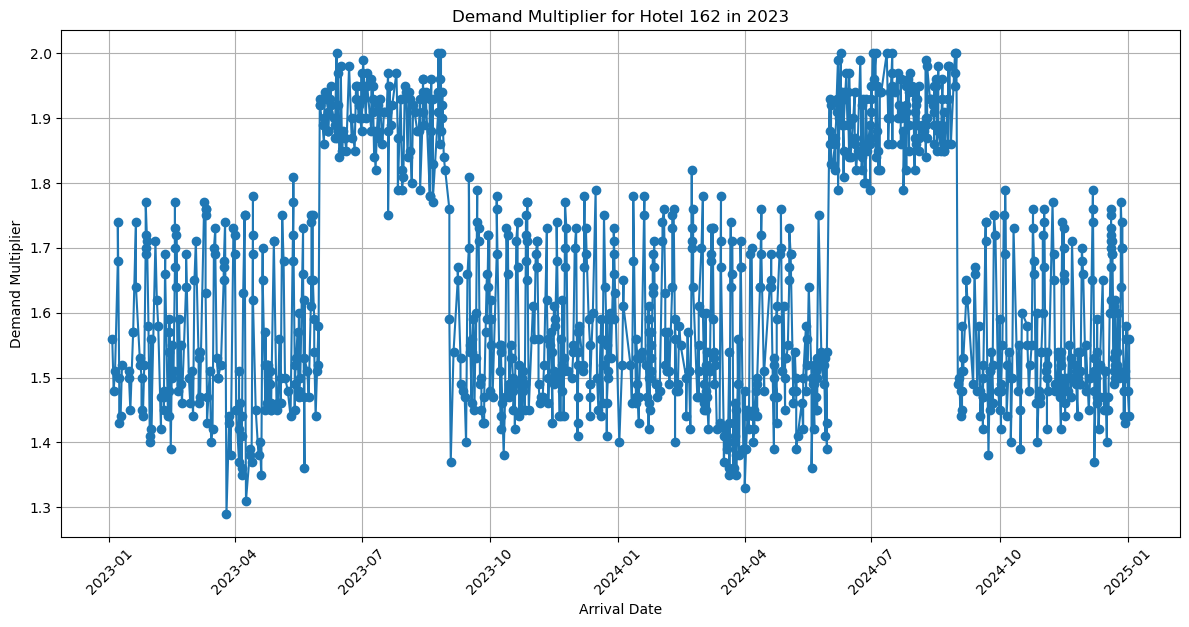

In [27]:
# Convert Arrival_Date column to datetime format
df['Arrival_Date'] = pd.to_datetime(df['Arrival_Date'], errors='coerce')
#162 is a 3* seaside resort hotel
df_filtered = df[(df['Hotel_id'] == 162) ]

# Sort by date
df_filtered = df_filtered.sort_values('Arrival_Date')

# 📊 Plot
plt.figure(figsize=(12, 6))
plt.plot(df_filtered['Arrival_Date'], df_filtered['Demand_Multiplier_res'], marker='o', linestyle='-')
plt.title('Demand Multiplier for Hotel 162 in 2023')
plt.xlabel('Arrival Date')
plt.ylabel('Demand Multiplier')
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()


In [38]:
# Example new booking data
new_booking = {
    'Reservation_Date': '2024-12-27',
    'Arrival_Date': '2024-12-29',
    'Is_Week_End(arr)': True,
    'Arr_Season': 'Winter',
    'Location': 'seaside',
    'Type': 'resort',
    'Nbre-Etoile': 3

    # Booking_Lead will be automatically calculated as 36 days
}


In [39]:
# Make prediction
predicted_demand = predict_demand_multiplier(new_booking)
print(f"Predicted demand multiplier: {predicted_demand:.4f}")
   

Predicted demand multiplier: 1.4980


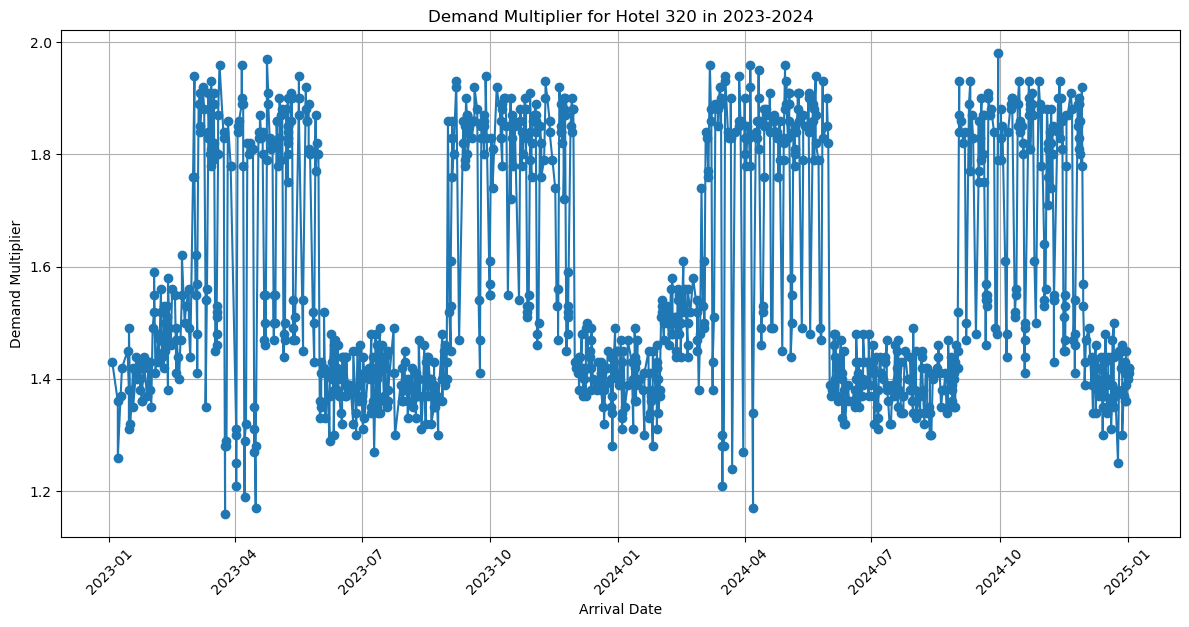

In [42]:
# Convert Arrival_Date column to datetime format
df['Arrival_Date'] = pd.to_datetime(df['Arrival_Date'], errors='coerce')
#320 is a 4* city business hotel
df_filtered = df[(df['Hotel_id'] == 320) ]

# Sort by date
df_filtered = df_filtered.sort_values('Arrival_Date')

# 📊 Plot
plt.figure(figsize=(12, 6))
plt.plot(df_filtered['Arrival_Date'], df_filtered['Demand_Multiplier_res'], marker='o', linestyle='-')
plt.title('Demand Multiplier for Hotel 320 in 2023-2024')
plt.xlabel('Arrival Date')
plt.ylabel('Demand Multiplier')
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

In [43]:
# Example new booking data
new_booking = {
    'Reservation_Date': '2026-10-01',
    'Arrival_Date': '2026-10-20',
    'Is_Week_End(arr)': False,
    'Arr_Season': 'Autumn',
    'Location': 'city',
    'Type': 'business',
    'Nbre-Etoile': 4

    # Booking_Lead will be automatically calculated as 36 days
}


In [44]:
# Make prediction
predicted_demand = predict_demand_multiplier(new_booking)
print(f"Predicted demand multiplier: {predicted_demand:.4f}")

Predicted demand multiplier: 1.9084


In [47]:
# Example new booking data
new_booking = {
    'Reservation_Date': '2026-10-01',
    'Arrival_Date': '2026-10-24',
    'Is_Week_End(arr)': True,
    'Arr_Season': 'Autumn',
    'Location': 'city',
    'Type': 'business',
    'Nbre-Etoile': 4

    # Booking_Lead will be automatically calculated as 36 days
}


In [48]:
# Make prediction
predicted_demand = predict_demand_multiplier(new_booking)
print(f"Predicted demand multiplier: {predicted_demand:.4f}")

Predicted demand multiplier: 1.4630
